In [1]:
import os
import sys
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from IPython.display import clear_output

if os.path.abspath(os.path.join(os.getcwd(), "../../")) not in sys.path:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
    
from plan_generator.src.config import Configuration
from plan_generator.src.enums import LabelsOld, LabelsNew, Colors
from plan_generator.src.models import PlanGenerator, WallGenerator, RoomAllocator, DiceLoss
from plan_generator.src.data import PlanDataset, PlanDataLoader
from plan_generator.src.trainer import PlanGeneratorTrainer

In [2]:
configuration = Configuration()
configuration.BATCH_SIZE = 1

plan_dataset = PlanDataset(slicer=1)
plan_dataloader = PlanDataLoader(plan_dataset)

plan_generator = PlanGenerator(configuration=configuration)
plan_generator_trainer = PlanGeneratorTrainer(plan_generator=plan_generator, plan_dataloader=plan_dataloader)

plan_generator_trainer.fit()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:444: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:444: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


/root/plan-generator/plan_generator/runs/08-27-2024__12-27-19


training...: 0it [00:00, ?it/s]
ERROR:tornado.general:SEND Error: Host unreachable


KeyboardInterrupt: 

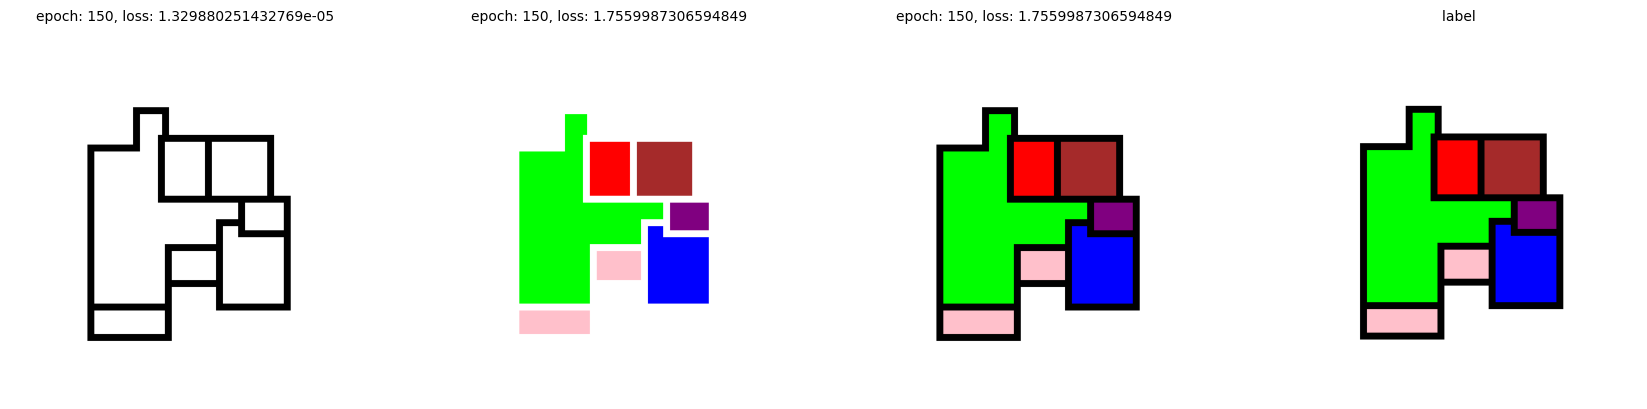

In [7]:
import cv2
from scipy import stats

channels_step = [64, 128, 256, 512, 1024]

wall_generator = WallGenerator(in_channels=1, out_channels=1, channels_step=channels_step, size=256, encoder_repeat=5)
wall_generator_loss_function = nn.BCELoss()
wall_generator_optimizer = torch.optim.Adam(wall_generator.parameters(), lr=0.0002)

room_allocator = RoomAllocator(
    in_channels=1, 
    out_channels=LabelsNew.NUM_CLASSES.value, 
    channels_step=[64, 128, 256, 512, 768, 896, 1024], 
    size=256, 
    encoder_repeat=5
)

room_allocator_loss_function = nn.CrossEntropyLoss()
# room_allocator_loss_function = DiceLoss(epsilon=1e-6)
room_allocator_optimizer = torch.optim.Adam(room_allocator.parameters(), lr=0.0002)

kernel = np.ones((10, 10), np.uint8) 

for epoch in range(1, 150 + 1):
    for floor, walls, rooms in plan_dataloader:
        
        wall_generator_optimizer.zero_grad()
        
        generated_walls = wall_generator(floor)
        masked_generated_walls = generated_walls.clone()
        masked_generated_walls[floor == 0] = 0
        
        wall_generator_loss = wall_generator_loss_function(masked_generated_walls, walls)
        
        wall_generator_loss.backward()
        wall_generator_optimizer.step()
        
        room_allocator_optimizer.zero_grad()
        
        generated_rooms = room_allocator(walls)
        masked_generated_rooms = generated_rooms.clone()
        masked_generated_rooms[floor.expand_as(generated_rooms) == 0] = 0
        
        room_allocator_loss = room_allocator_loss_function(masked_generated_rooms, rooms.squeeze(1))
        room_allocator_loss.backward()
        room_allocator_optimizer.step()
        
        walls_to_visualize = masked_generated_walls.permute(0, 2, 3, 1)
        walls_to_visualize = (walls_to_visualize.detach().cpu().numpy() > 0.5).astype(int)
        walls_to_visualize = np.where(walls_to_visualize == 0, 255, 0)[0]
        walls_to_visualize = walls_to_visualize.astype(np.uint8).squeeze(-1)
        walls_to_visualize = cv2.erode(walls_to_visualize.astype(np.uint8), kernel, iterations=1)
        walls_to_visualize = cv2.dilate(walls_to_visualize.astype(np.uint8), kernel, iterations=1)
        
        rooms_to_visualize = torch.argmax(masked_generated_rooms, dim=1)
        rooms_to_visualize = rooms_to_visualize.detach().cpu().numpy()
        rooms_to_visualize = np.transpose(rooms_to_visualize, (1, 2, 0))
        rooms_to_visualize = rooms_to_visualize.astype(np.uint8).squeeze(-1)
        rooms_to_visualize = cv2.erode(rooms_to_visualize.astype(np.uint8), kernel, iterations=1)
        rooms_to_visualize = cv2.dilate(rooms_to_visualize.astype(np.uint8), kernel, iterations=1)
        
        # num_labels, labels = cv2.connectedComponents(rooms_to_visualize, connectivity=4)
        # for label in range(1, num_labels):
        #     values = rooms_to_visualize[labels == label]
        #     most_common = stats.mode(values).mode
        #     rooms_to_visualize[mask] = most_common
        
        # Create an empty RGB image
        rooms_channel_3 = np.zeros((rooms_to_visualize.shape[0], rooms_to_visualize.shape[1], 3), dtype=np.uint8)
        rooms_channel_3 += Colors.WHITE.value[0]

        # Map each label to its corresponding color
        for label, color in Colors.COLOR_MAP_NEW.value.items():
            mask = rooms_to_visualize == label
            rooms_channel_3[:, :, 0][mask] = color[0]
            rooms_channel_3[:, :, 1][mask] = color[1]
            rooms_channel_3[:, :, 2][mask] = color[2]
            
        walls_and_rooms = rooms_channel_3.copy()
        walls_and_rooms[:, :, 0][walls_to_visualize == 0] = Colors.BLACK.value[0]
        walls_and_rooms[:, :, 1][walls_to_visualize == 0] = Colors.BLACK.value[1]
        walls_and_rooms[:, :, 2][walls_to_visualize == 0] = Colors.BLACK.value[2]
        
        # Create to visualize the label image
        walls_np = walls.detach().cpu().numpy().squeeze(0).squeeze(0)
        rooms_np = rooms.detach().cpu().numpy().squeeze(0).squeeze(0)
        
        original_walls_and_rooms_channel_3 = np.zeros(
            (rooms_to_visualize.shape[0], rooms_to_visualize.shape[1], 3), dtype=np.uint8
        )
        
        original_walls_and_rooms_channel_3 += Colors.WHITE.value[0]
        original_walls_and_rooms_channel_3[:, :, 0][walls_np == 1] = Colors.BLACK.value[0]
        original_walls_and_rooms_channel_3[:, :, 1][walls_np == 1] = Colors.BLACK.value[1]
        original_walls_and_rooms_channel_3[:, :, 2][walls_np == 1] = Colors.BLACK.value[2]
        
        for label, color in Colors.COLOR_MAP_NEW.value.items():
            mask = rooms_np == label
            original_walls_and_rooms_channel_3[:, :, 0][mask] = color[0]
            original_walls_and_rooms_channel_3[:, :, 1][mask] = color[1]
            original_walls_and_rooms_channel_3[:, :, 2][mask] = color[2]
        
        fig, axes = plt.subplots(1, 4, figsize=(21, 7))
        ax_1, ax_2, ax_3, ax_4 = axes.flatten()
        ax_1.imshow(walls_to_visualize, cmap="gray")  # Assuming single-channel output
        ax_1.axis('off')
        ax_1.set_title(f"epoch: {epoch}, loss: {wall_generator_loss.item()} \n", fontsize=10)
        
        ax_2.imshow(rooms_channel_3)
        ax_2.axis('off')
        ax_2.set_title(f"epoch: {epoch}, loss: {room_allocator_loss.item()} \n", fontsize=10)
        
        ax_3.imshow(walls_and_rooms)
        ax_3.axis('off')
        ax_3.set_title(f"epoch: {epoch}, loss: {room_allocator_loss.item()} \n", fontsize=10)
        
        ax_4.imshow(original_walls_and_rooms_channel_3)
        ax_4.axis('off')
        ax_4.set_title(f"label \n", fontsize=10)
        
        plt.show()
        clear_output(wait=True) 
        